## Linear Elastic Phase Field Fracture 

In this tutorial, we model the deformation and fracture of linear elastic materials using FEniCSx. 

Consider a 2D beam $\Omega = \{(x,y): x\in (0, L),\; y\in (0,W)\}$. The beam is fixed on the left edge (at $ x=0 $),  $\Gamma_l = \{(x,y) \in \Omega: x = 0\}$, the beam's displacement is restricted in the y-direction on the bottom edge (at $ y = 0 $), $\Gamma_b = \{(x,y) \in \Omega: y=0\}$, and is subjected to a perscribed displacment $\boldsymbol{u_D}$ on the right surface (at $x=L$), $\Gamma_r = \{(x,y) \in \Omega: x = L\}$. 

In this model we assume that the strain is confined to the small strain theory, that the materials are homogeneous, elastic, isotropic brittle materials. Additionlly, the effects of geometrical nonlinearities and possible non-symetric behavior in the damaged portions being ignored for simplicity. 

The energy functional for the phase field fracture for the brittle fracture of a solid is formulated below: 

\begin{equation}
    \mathcal{E}_{tot}(u,\alpha) = \mathcal{E}_{elas}(u,\alpha)+\mathcal{E}_{frac}(\alpha)-\mathcal{W}_{ext}(u)
\end{equation} 

Where $\mathcal{E}_{tot}$ represents the total energy, $\mathcal{E}_{elas}$ represents the elastic energy, $\mathcal{E}_{frac}$ represents the fracture energy, and $\mathcal{W}_{ext}$ is the work done by external forces, which are represented as follows,
\begin{equation}
    \mathcal{E}_{elas}(u,\alpha) = \frac{1}{2}\int_{\Omega}a(\alpha)\epsilon:\mathbf{C}:\epsilon   dx
\end{equation}
\begin{equation}
    \mathcal{E}_{frac}(\alpha) = \frac{G_c}{4*c_w}\int_{\Omega}\frac{w(\alpha)}{l}+l||\nabla\alpha||^2dx
\end{equation}
\begin{equation}
    \mathcal{W}_{ext}(u) = \int_{\Omega}f\cdot u dx
\end{equation}

Where, $ u $ is the displacement, $ \epsilon(u) $ is the linearized strain function shown below, and $ \mathbf{C} $ is the fourth-order elasticity tensor of the material before it is damaged. $ G_c$ is the critical fracture energy, $ l $ is the regularization length scale parameter, $f$ is the external force and $ \alpha \in [0,1]$ is the continuous field that represents the crack. Where, $ \alpha = 0 $ represents the undamaged material and $ \alpha = 1 $ represents the damaged or cracked material.

\begin{equation}
    \epsilon(u) = \nabla u(x) + (\nabla u(x))^T
\end{equation}

The degradation function $a(\alpha)$, the strictly increasing function $w(\alpha)$, and it's corresponding constant $c_w$ for the linear elastic case are as follows.
\begin{equation}
    a(\alpha) = (1 - \alpha)^2 + k_{res}
\end{equation}
\begin{equation}
    w(\alpha) = \alpha, 
    c_w = \int_{0}^{1}\sqrt{w(\alpha)}d\alpha =  \frac{2}{3} 
\end{equation}

### Geometrical, material, and external loading parameters and functions
In what follows, we let $ L = 1 mm $ and $ H = 0.3 mm $. We assume that there is no applied body force, i.e., $ f = 0 $. The perscribed displacement $ \boldsymbol u_D = 2.57407488 mm $ applied on the x-direction only on the right edge $ \Gamma_r $. 

As for the material properties, we take Young's modulus $E = MPa $, Poisson ratio $\nu = $, critical fracture energy $ G_c =  N/mm $. These properties are typical of rubber-like materials. 


#### FEniCSx implementation 
We start by loading in the relavent packages

In [1]:
# dolfinx from the fenicx library with specific functions 
import dolfinx 
from dolfinx import mesh, fem, plot, io, la 
from dolfinx.io import gmshio
import dolfinx.fem.petsc
import petsc4py
from petsc4py import PETSc
import gmsh

# mpi4py for parallel execution 
import mpi4py
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

# scientific computation and math 
import numpy as np 
import sympy
import ufl

# plotting and visualization 
import matplotlib.pyplot as plt
import pyvista 

import os 
import sys 
from typing import Optional

#specific functions from supporting modules 
from solvers import LinearSolver, AlphaSolver
from func import create_functions, AltMin, MeshPlotter, material_properties, unpack_functions
from form_prob import form_prob
from bound_cond import perscribed_disp_x, perscribed_disp_y

Next, we create a results directory. 

In [2]:
# Results folder labeled for the geometry of the model and the direction of loading 
results_folder = "pfm_result/notched_x"
if rank == 0: 
    os.makedirs(results_folder, exist_ok=True)

Now, the model and the mesh are created using the gmsh library.

In [3]:
gmsh.initialize()

# Creates and names the model 
gmsh.model.add("notched_F")

# Build geometry
# Creates points at the verticies of the model 
gmsh.model.occ.addPoint(0, 0, 0, 0.1, 1)
gmsh.model.occ.addPoint(1, 0, 0, 0.1, 2)
gmsh.model.occ.addPoint(1, 0.3, 0, 0.1, 3)
gmsh.model.occ.addPoint(0, 0.3, 0, 0.1, 4)
gmsh.model.occ.addPoint(0.255, 0, 0, 0.1, 5)
gmsh.model.occ.addPoint(0.265, 0, 0, 0.1, 6)
gmsh.model.occ.addPoint(0.26, 0.03, 0, 0.1, 7)
# Creates the lines that connect the vertices of the model 
gmsh.model.occ.addLine(1, 5, 1)
gmsh.model.occ.addLine(5, 7, 2)
gmsh.model.occ.addLine(7, 6, 3)
gmsh.model.occ.addLine(6, 2, 4)
gmsh.model.occ.addLine(2, 3, 5)
gmsh.model.occ.addLine(3, 4, 6)
gmsh.model.occ.addLine(4, 1, 7)
gmsh.model.occ.addLine(1, 2, 8)
# Creates the curve loop used to define the plane surface 
gmsh.model.occ.addCurveLoop([1, 2, 3, 4, 5, 6, 7], 1)
# Creates the plane surface of the model
gmsh.model.occ.addPlaneSurface([1], 1)

gmsh.model.occ.synchronize()

# Adds physical groups
gmsh.model.addPhysicalGroup(2, [1], 1)  # 2D surface
gmsh.model.addPhysicalGroup(1, [1, 2, 3, 4, 5, 6, 7], 6)  # 1D boundary lines

# Gets the boundaries and creating boundary arrays 
boundary = gmsh.model.getBoundary([(2, 1)], oriented=False)
xBot, xTop, yBot, yTop = [], [], [], []
for dim, tag in boundary:
    x, y, _ = gmsh.model.occ.getCenterOfMass(dim, tag)
    if np.isclose(x, 0.0, atol=1e-6):
        xBot.append(tag)
    elif np.isclose(x, 1.0, atol=1e-6):
        xTop.append(tag)
    elif np.isclose(y, 0.0, atol=1e-6):
        yBot.append(tag)
    elif np.isclose(y, 0.3, atol=1e-6):
        yTop.append(tag)    

# Adds physical groups for boundaries 
gmsh.model.addPhysicalGroup(1, xBot, 2)
gmsh.model.setPhysicalName(1, 2, "xBot")
gmsh.model.addPhysicalGroup(1, xTop, 3)
gmsh.model.setPhysicalName(1, 3, "xTop")
gmsh.model.addPhysicalGroup(1, yTop, 4)
gmsh.model.setPhysicalName(1, 4, "yTop")
gmsh.model.addPhysicalGroup(1, yBot, 5)
gmsh.model.setPhysicalName(1, 5, "yBot")

# Sets the regularization length scale range 
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 0.01)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 0.015)

# Generates the mesh 
gmsh.model.mesh.generate(2)
gmsh.write("notched_rectangle.msh")
print("Mesh Written")

# Converts to dolfinx mesh
domain, cell_tags, facet_tags = gmshio.model_to_mesh(gmsh.model, comm=MPI.COMM_WORLD, rank=0, gdim=2)
print("Mesh Imported")

gmsh.finalize()


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 40%] Meshing curve 4 (Line)
Info    : [ 60%] Meshing curve 5 (Line)
Info    : [ 70%] Meshing curve 6 (Line)
Info    : [ 80%] Meshing curve 7 (Line)
Info    : [ 90%] Meshing curve 8 (Line)
Info    : Done meshing 1D (Wall 0.00170221s, CPU 0.002869s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.154655s, CPU 0.15096s)
Info    : 1846 nodes 3632 elements
Info    : Writing 'notched_rectangle.msh'...
Mesh Written
Info    : Done writing 'notched_rectangle.msh'
Mesh Imported


Next, we create the domain topology and the connectivity. Additionally, we run the MeshPlotter to visualize the mesh. 

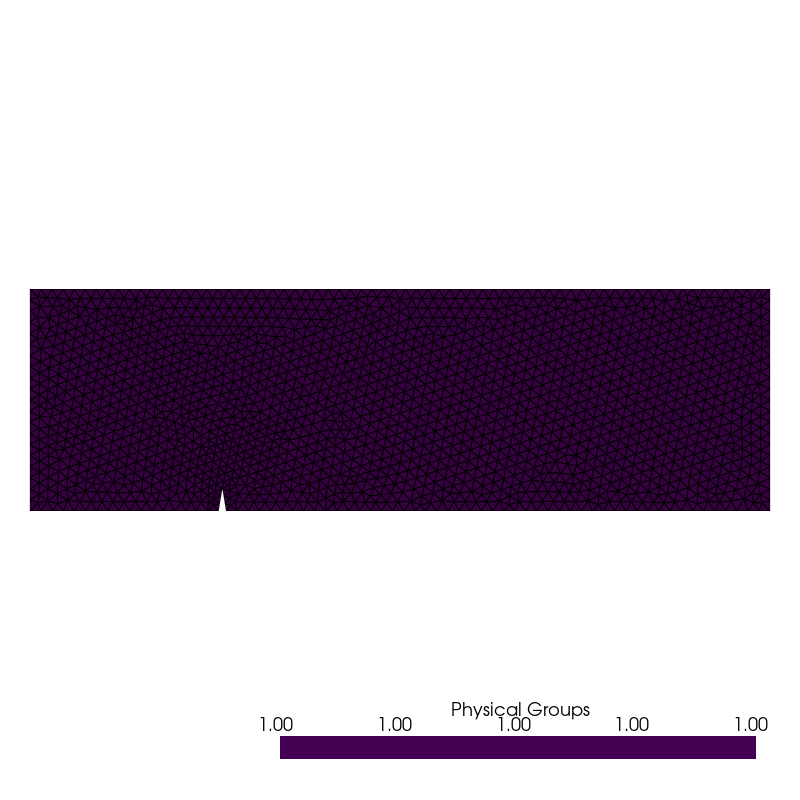

In [4]:
# Creates the domain topology and the connectivity
tdim = domain.topology.dim
domain.topology.create_connectivity(tdim, tdim)

# Plots the geometry and mesh
plotter = MeshPlotter(domain, tdim, cell_tags)
plotter.plot()

Then we define the material properties, and the dimesions of the model. 

In [5]:
omega_L, omega_H = 1.0, 0.3 #mm
# material_1 = {"E1": 7000, "Gc1": 5.497e-6, "nu1": 0.2} 
# # E: Mpa, Gc: N/mm, nu: unitless
# material_2 = {"E2": 50000, "Gc2": 1.886, "nu2":0.2}
material_1 = {"E1": 1.84, "Gc1": 0.0489, "nu1": 0.3}
# E: Mpa, Gc: N/mm, nu: unitless
material_2 = {"E2": 1600000, "Gc2": 0.189, "nu2":0.24}
top_tag = 1

properties = material_properties(material_1, material_2, domain, cell_tags, top_tag)

Tag 1 has 3379 cells


In [6]:
matl_type = {"hyperelastic": False} #Selecting the material model type

#Setting initial values fo later calculations 
ell_ = 0.01 # Characteristic length 
E_0 = fem.Constant(domain, PETSc.ScalarType(material_1["E1"])) # young's modulus
Gc_0 = fem.Constant(domain, PETSc.ScalarType(material_1["Gc1"])) # Critical Fracture energy 

conditions = {"E_0": E_0, "Gc_0": Gc_0, "ell_": ell_}

Then the test and trial functions and funciton spaces are created for both the displacement and damage variables. 

In [7]:
state, spaces, bounds, dx, ds = create_functions(domain) # Creating the test and trial functions and spaces 
u, alpha, alpha_low, alpha_up, V_u, V_alpha = unpack_functions(state, spaces, bounds) #Unpacking the variables from their dictionaries 

The boundary conditions and initital loading are then created using the bound_cond module. The loading is a perscribed displacement 

In [8]:
bcu, bcalpha, u_D = perscribed_disp_x(domain, V_u, V_alpha, facet_tags) # Establishes the boundary conditions and the loading 
bcs = {"bcu": bcu, "bcalpha": bcalpha} # Dictionary of combined boundary conditions 

Now we create the total energy functional, the initial guess for the loading, and establish the displacemnt and damage solvers.

In [9]:
total_energy, init, solver_u, damage_problem = form_prob(state, conditions, properties, tdim, dx, domain, matl_type, spaces, bcs, bounds)

c_w =  8/3
ell =  0.01
init =  0.00017160499171694368


### Results 
The results file is a .bp file which is readable in paraview version 5.11.2. The results are viewed by adjusting the coloring tab to either damage or displacement, and setting the automatic rescale range mode to clamp and update at every timestep. 

In [10]:
#Creates a folder and sets up the ability to write the displacement and the damage to .bp file readable in parview
filename = results_folder + "/solution"
file_results = io.VTXWriter(domain.comm, filename + ".bp", [u,alpha], engine="BP4")

Then, we apply the perscribed displacement in increments to the model. 

In [11]:
#!!Unchanged from newfrac-fenicsx-training!! alpha_low us renamed for clarity
load0 = float(init)*omega_L # reference value for the loading (imposed displacement)
loads = load0*np.linspace(0, 15000, 500)

energies = np.zeros((len(loads),4))
iterations = np.zeros((len(loads),2))

alt_min_parameters = {"atol": 1.e-6,"max_iter": 100}

with alpha.x.petsc_vec.localForm() as alpha_local:
    alpha_local.set(0)

for i_t, t in enumerate(loads):
    u_D.value = t
        
    # update the lower bound
    alpha.x.petsc_vec.copy(alpha_low.x.petsc_vec)    
    print(f"-- Solving for t = {t:3.2f} --")
    alt_min = AltMin(state, alt_min_parameters, dx, solver_u, damage_problem, file_results, load=t)
    alt_min.alternate_minimization(parameters=alt_min_parameters, monitor=alt_min.simple_monitor)
    file_results.write(i_t)

-- Solving for t = 0.00 --
Load: 0.000000e+00, Iteration:   0, Error: 0.0000e+00
  max(alpha) = 0.0000e+00, min(alpha) = 0.0000e+00
  max(u) = 0.0000e+00, min(u) = 0.0000e+00
-- Solving for t = 0.01 --
Load: 5.158467e-03, Iteration:   0, Error: 0.0000e+00
  max(alpha) = 0.0000e+00, min(alpha) = 0.0000e+00
  max(u) = 5.1585e-03, min(u) = 0.0000e+00
-- Solving for t = 0.01 --
Load: 1.031693e-02, Iteration:   0, Error: 0.0000e+00
  max(alpha) = 0.0000e+00, min(alpha) = 0.0000e+00
  max(u) = 1.0317e-02, min(u) = 0.0000e+00
-- Solving for t = 0.02 --
Load: 1.547540e-02, Iteration:   0, Error: 0.0000e+00
  max(alpha) = 0.0000e+00, min(alpha) = 0.0000e+00
  max(u) = 1.5475e-02, min(u) = 0.0000e+00
-- Solving for t = 0.02 --
Load: 2.063387e-02, Iteration:   0, Error: 0.0000e+00
  max(alpha) = 0.0000e+00, min(alpha) = 0.0000e+00
  max(u) = 2.0634e-02, min(u) = 0.0000e+00
-- Solving for t = 0.03 --
Load: 2.579233e-02, Iteration:   0, Error: 0.0000e+00
  max(alpha) = 0.0000e+00, min(alpha) = 0.00